In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import classification_efficacy_metrics

In [3]:
from holisticai.datasets import load_adult

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1), dtype=float)
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [4]:
from sklearn.linear_model import LogisticRegression
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility

# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split

model = LogisticRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
classification_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
Accuracy,0.803665,1
Balanced Accuracy,0.618640,1
Precision,0.714781,1
Recall,0.270306,1
F1-Score,0.392269,1


# Global Explainability Metrics (based on Permutation Feature Importance)

In [5]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_pred)

The accumulated feature importance for 2 features is equal 0.7994 < 0.8.


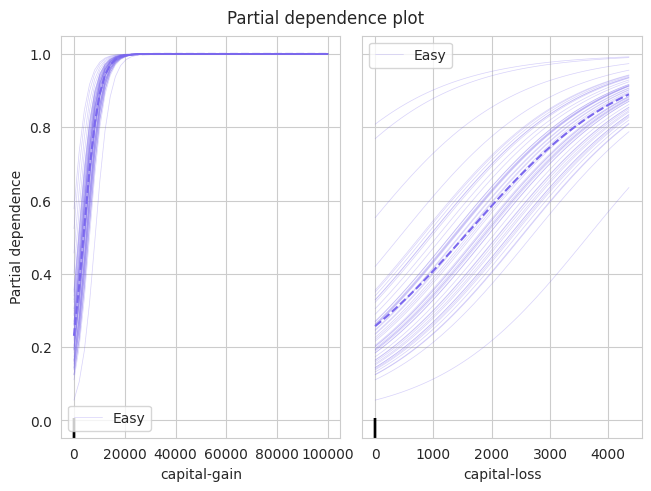

In [6]:
permutation_explainer.partial_dependence_plot(kind='both')

In [7]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Explainability Ease,1.000000,1
Fourth Fifths,0.020408,0
Fourth Fifths [label=0],0.020408,0
Fourth Fifths [label=1],0.020408,0
Important Similarity,0.955618,1
Important Similarity [label=0],0.967631,1
Important Similarity [label=1],0.943604,1
Position Parity,0.954926,1
Position Parity [label=0],0.909851,1


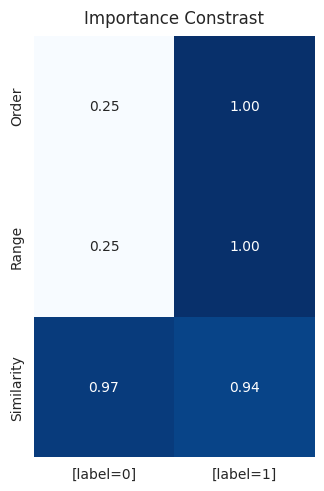

In [8]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

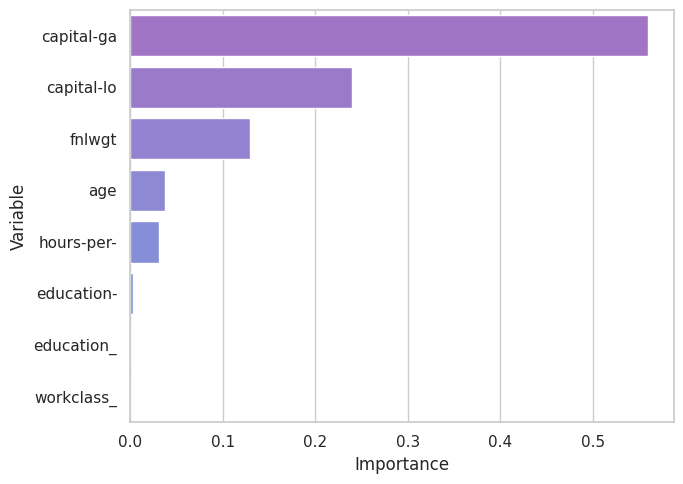

In [9]:
permutation_explainer.bar_plot(max_display=10)

In [10]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[label=0] Importance,[label=1] Importance
Variable,,,
capital-gain,0.560060,nan,0.378503
capital-loss,0.239339,0.281780,0.339837
fnlwgt,nan,0.402542,nan


In [11]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [12]:
surrogate_explainer.metrics()

,Value,Reference
Metric,,
Explainability Ease,0.994898,1
Fourth Fifths,0.010204,0
Spread Divergence,3.768813,-
Spread Ratio,0.178007,0
Surrogacy Efficacy,0.988309,1


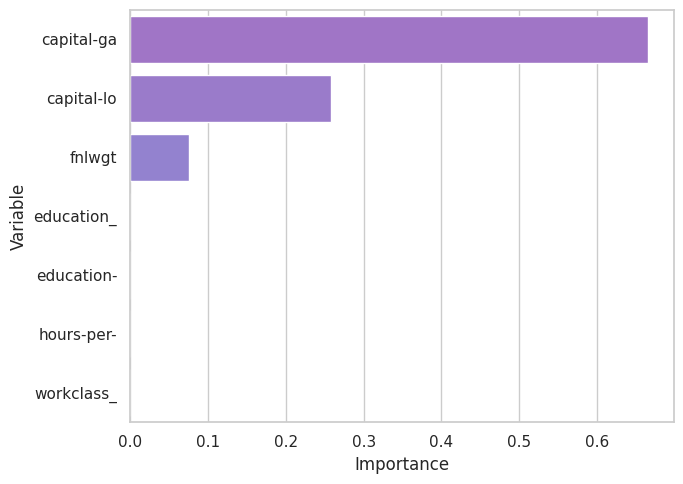

In [13]:
surrogate_explainer.bar_plot(max_display=10)

The accumulated feature importance for 1 features is equal 0.6658 < 0.8.


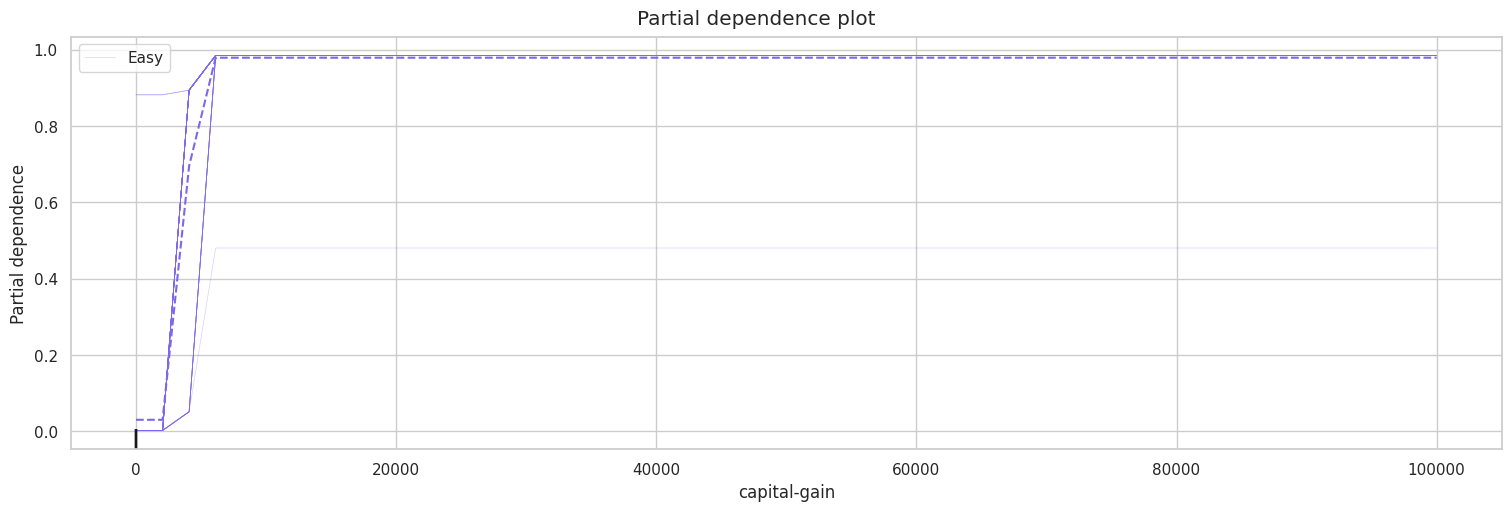

In [14]:
_,ax = plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(last=3, ax=ax, kind='both')

In [15]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
capital-gain,0.665819


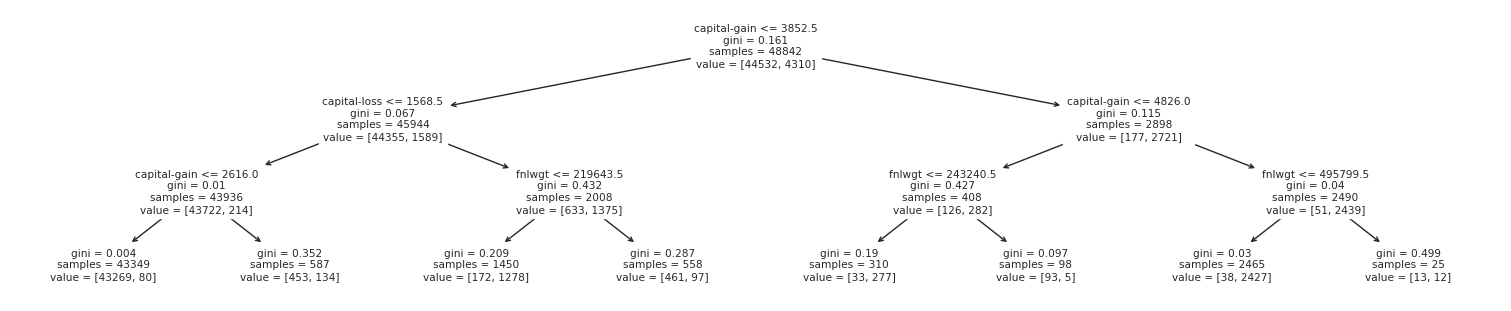

In [16]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

In [17]:
%pip install pydotplus dtreeviz

Note: you may need to restart the kernel to use updated packages.


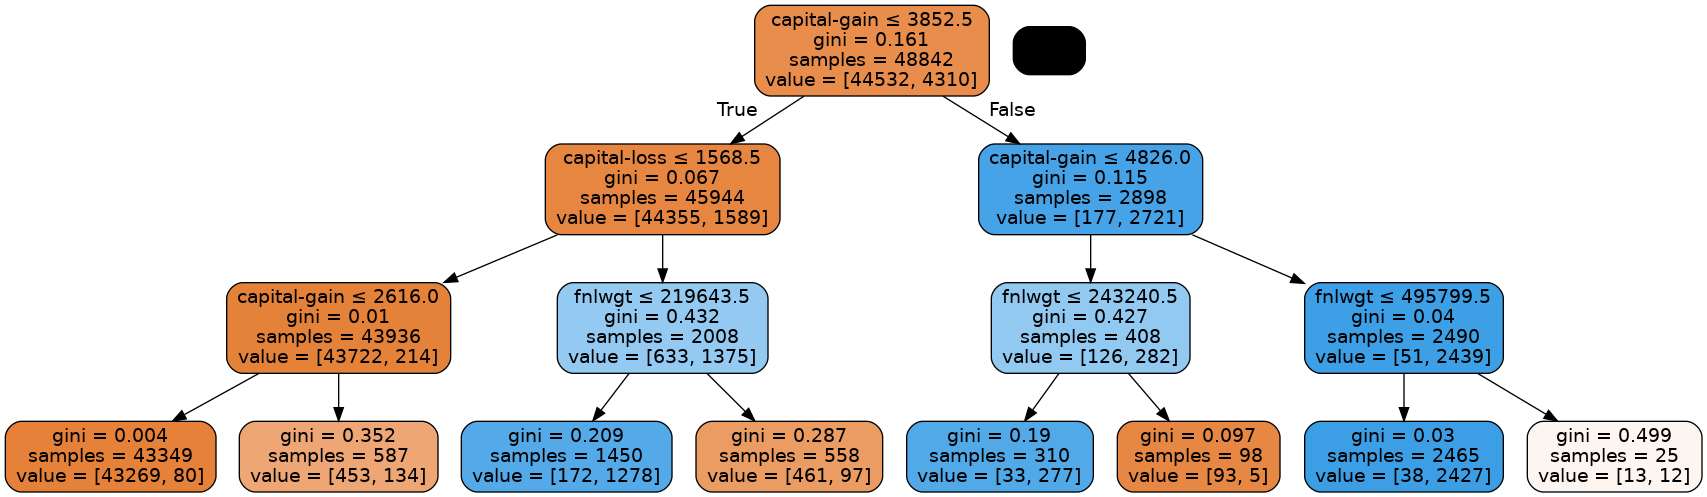

In [18]:
surrogate_explainer.tree_visualization('pydotplus')

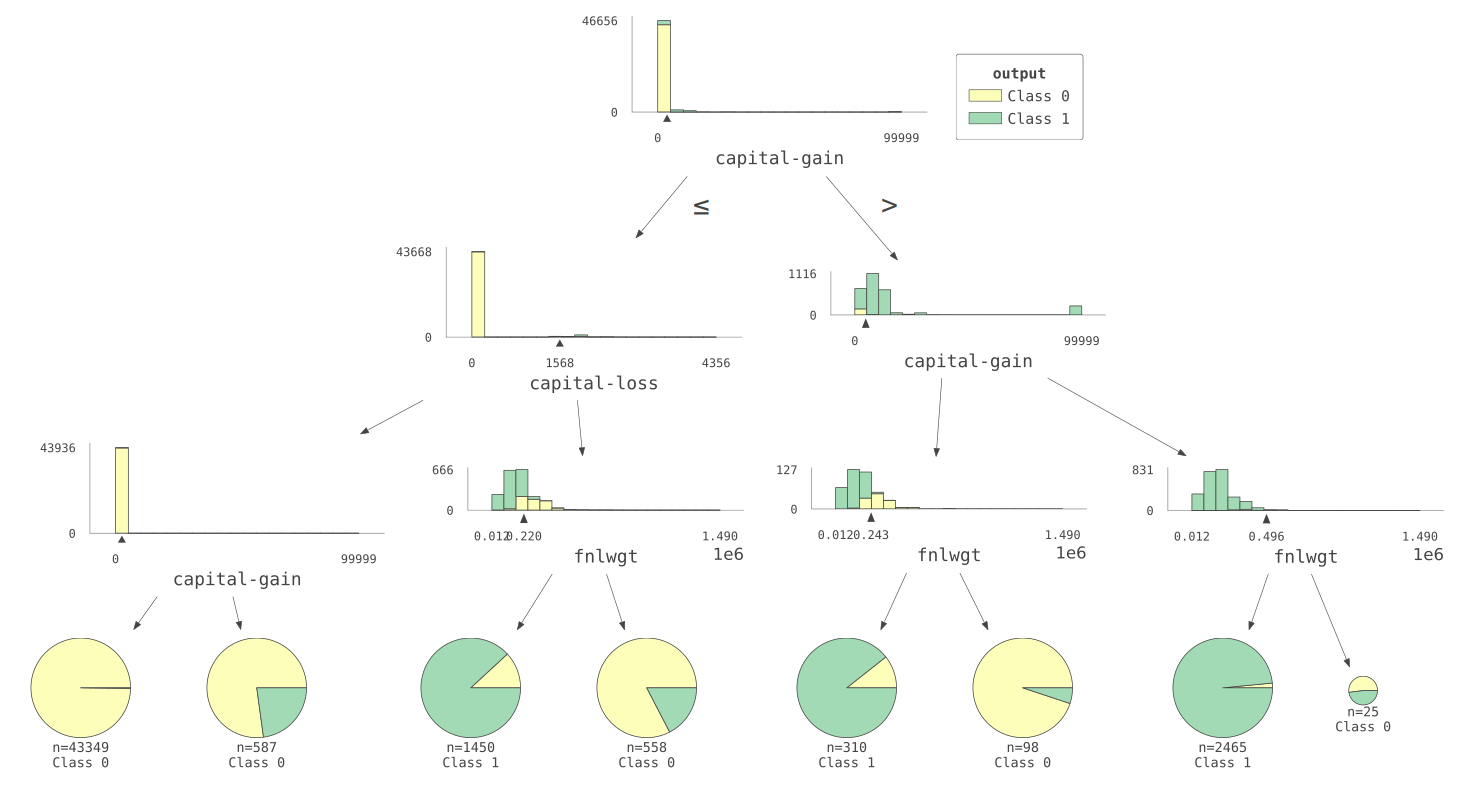

In [19]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [20]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [21]:
lime_explainer.metrics(detailed=False)

,Value,Reference
Metric,,
Data Stability,0.027808,0
Feature Stability,0.046038,0


In [22]:
lime_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Data Stability,0.027808,0
Data Stability [label=0],0.027660,0
Data Stability [label=1],0.027947,0
Feature Stability,0.046038,0
Feature Stability [label=0],0.056299,0
Feature Stability [label=1],0.052583,0


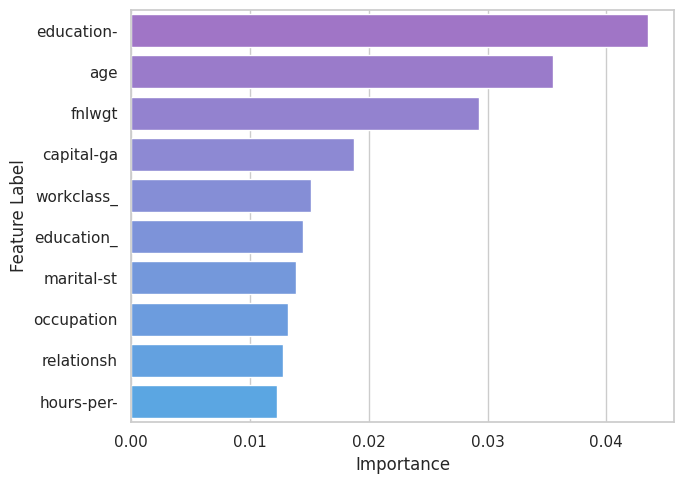

In [23]:
lime_explainer.bar_plot(max_display=10)

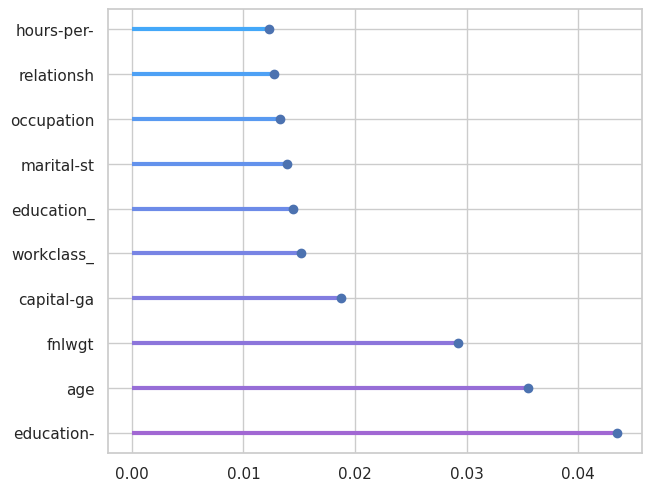

In [24]:
lime_explainer.lolipop_plot(max_display=10)

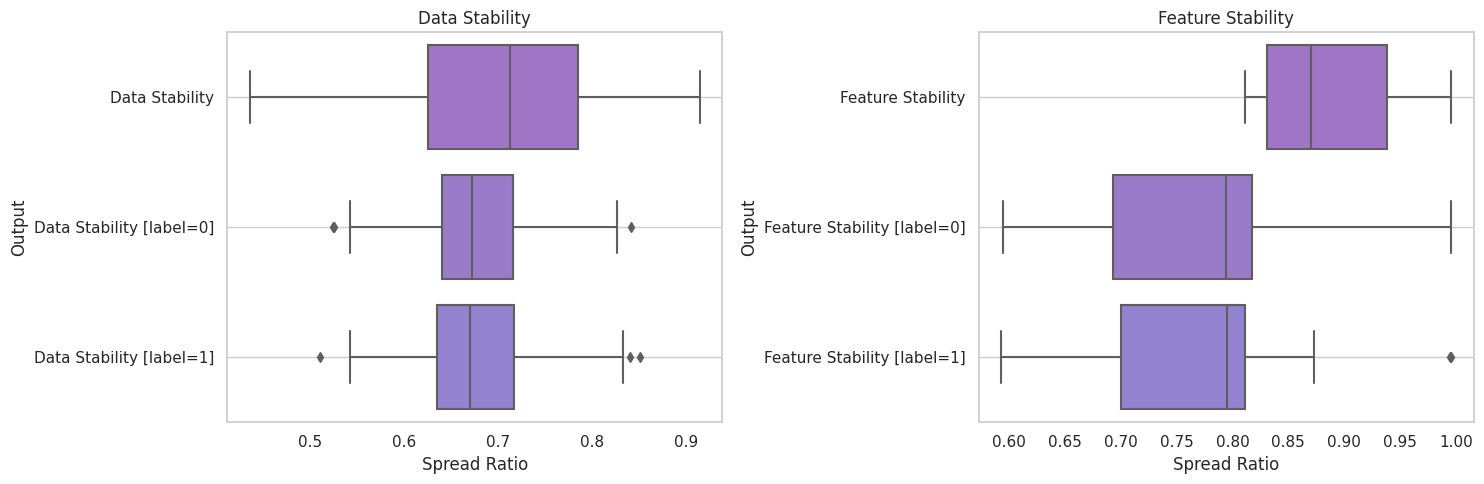

In [25]:
lime_explainer.show_importance_stability()

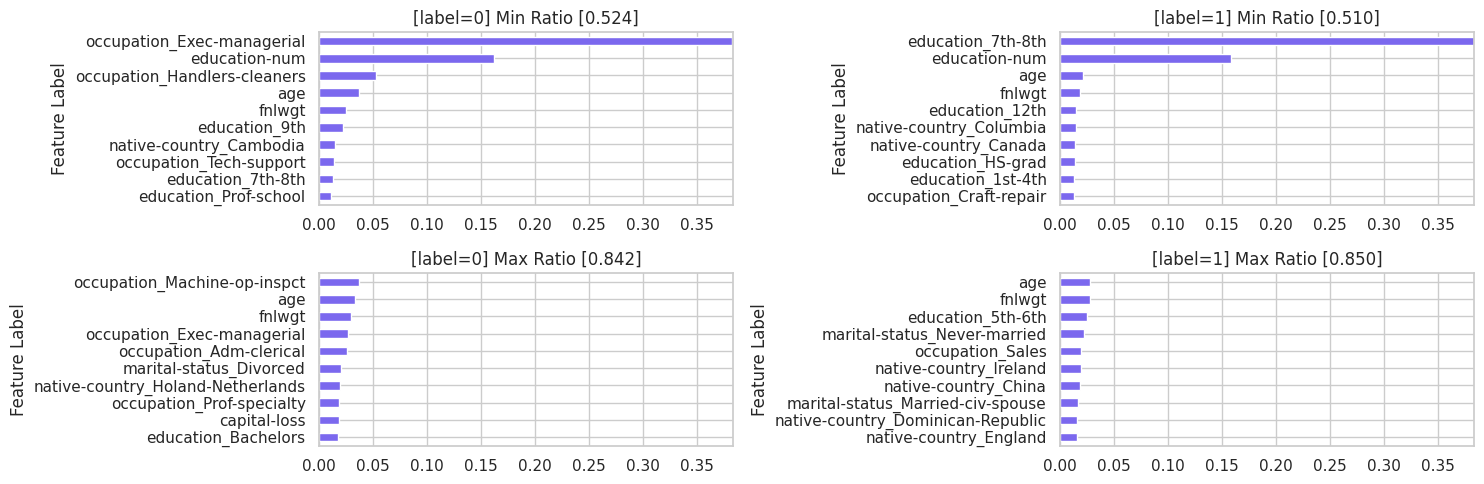

In [26]:
lime_explainer.show_data_stability_boundaries(top_n=10, n_cols=2, figsize=(15,5))

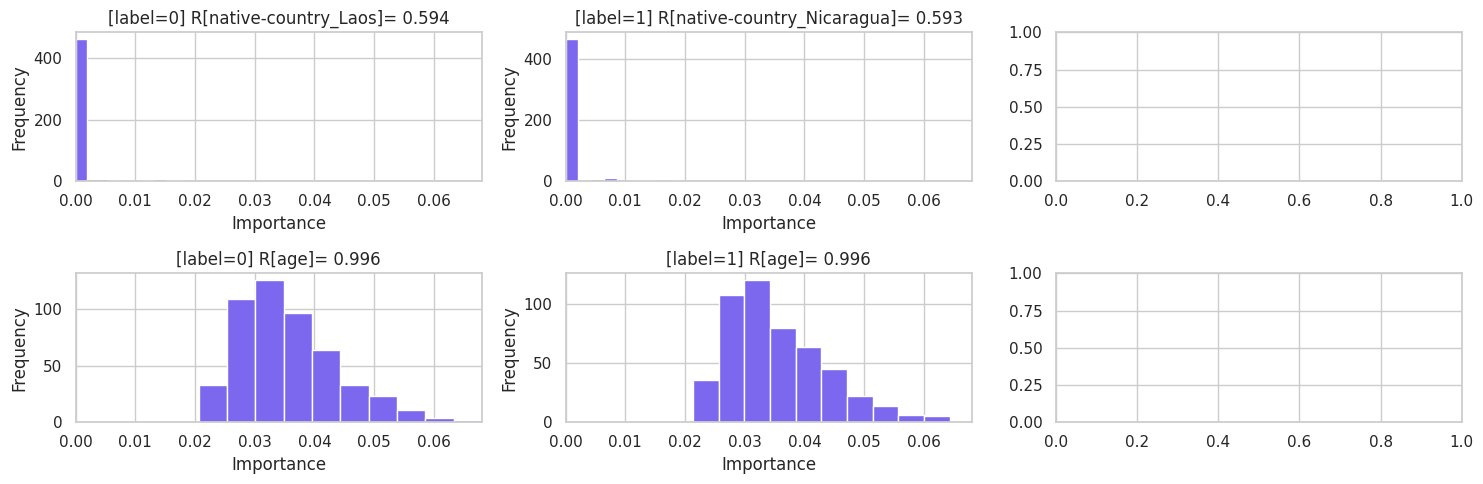

In [27]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))

# Local Explainability Metrics (SHAP)

In [28]:
# lime feature importance
shap_explainer = Explainer(based_on='feature_importance',
                      strategy_type='shap',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

Permutation explainer: 1001it [00:34, 18.20it/s]                         


In [29]:
shap_explainer.metrics(detailed=False)

,Value,Reference
Metric,,
Data Stability,0.144029,0
Feature Stability,0.095850,0


In [30]:
shap_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Data Stability,0.144029,0
Data Stability [label=0],0.068931,0
Data Stability [label=1],0.213404,0
Feature Stability,0.095850,0
Feature Stability [label=0],0.101220,0
Feature Stability [label=1],0.087033,0


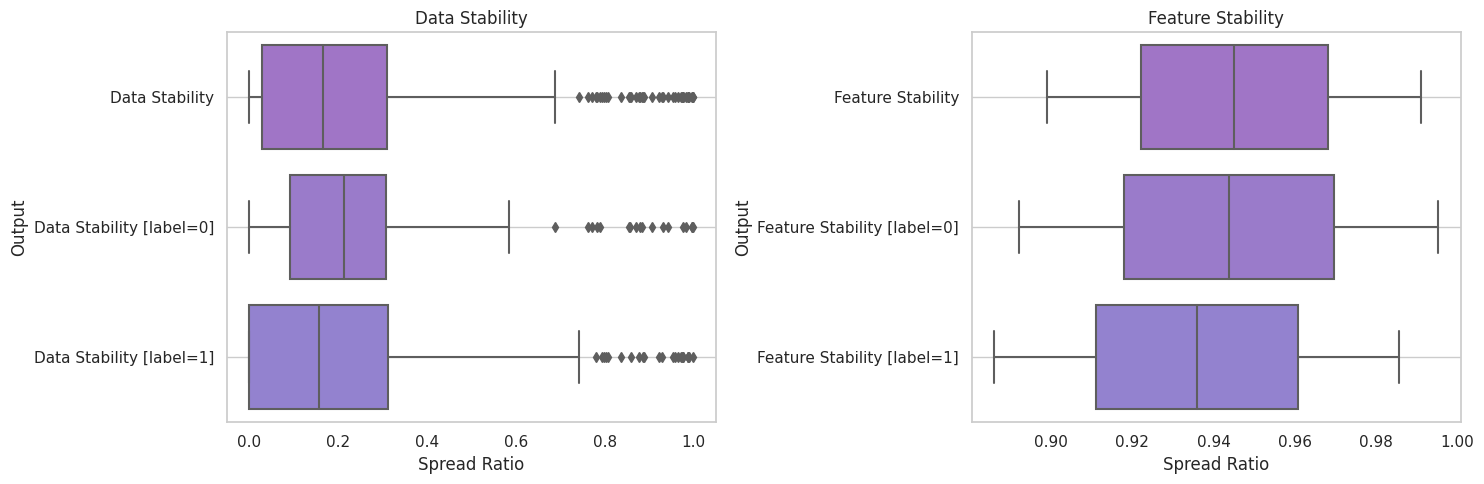

In [31]:
shap_explainer.show_importance_stability()

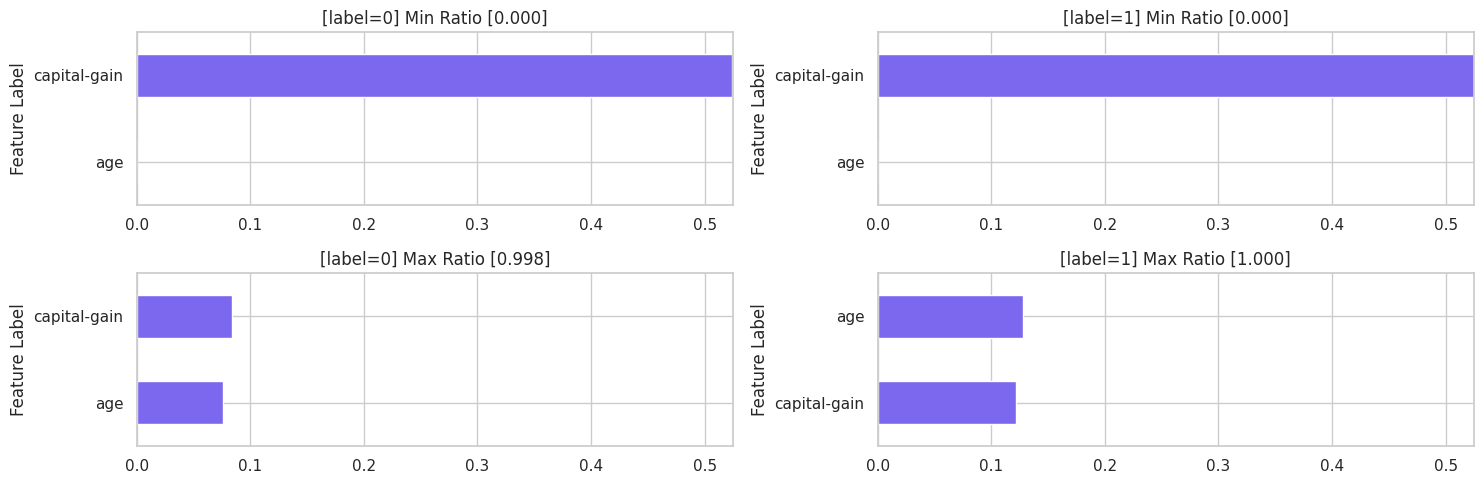

In [32]:
shap_explainer.show_data_stability_boundaries(top_n=5, n_cols=2, figsize=(15,5))

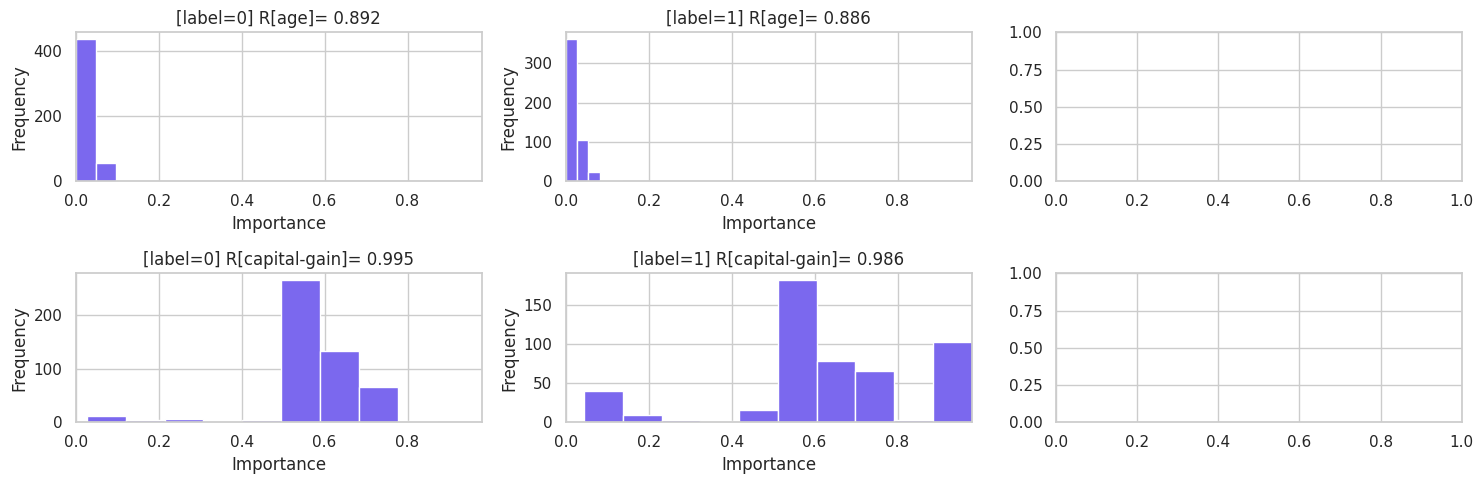

In [33]:
shap_explainer.show_features_stability_boundaries(figsize=(15,5))